In [ ]:
import pandas as pd
from custom_package import custom_package as bh
import us
from us import states
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


## Defining queries to pull data from SQL and creating helper functions

In [ ]:
# defining time interval for the analysis 
startdate = '2023-10-31'
enddate = '2024-10-31'

In [ ]:
MAILING_CODE_QUERY = """SELECT mailing_code FROM mailing_table WHERE pubdate BETWEEN '{}' AND '{}'
AND fromaddress LIKE '%example.com' 
AND publicationid NOT IN ('example_exclusion')
AND publicationid NOT LIKE '%example_pre'
AND publicationid NOT LIKE '%example_test'""".format(startdate, enddate)

DELIVERED_QUERY = """SELECT mailing_code, state, recipient_id
FROM delivered_table
WHERE mailing_code = '{mailing_code}'
AND is_usa = 1
AND list_type='M' """

CLICKS_QUERY =  """ SELECT DISTINCT mailing_code, state, recipient_id
FROM events_table 
INNER JOIN recipients_table r ON (recipient_id = cbm_id)
WHERE mailing_code = '{mailing_code}'
AND event_type = 'c' # fits the click event type
AND is_usa = 1																	
AND list_type='M'"""

In [ ]:
# cleaning function: recoding states in to standard abbreviations or replacing with null any invalid entries for state which will be removed later
def recode_state(state):
    if pd.isnull(state):
        return None
    if len(state) == 2 and us.states.lookup(state):
        return state
    try:
        return us.states.lookup(state).abbr
    except AttributeError:
        return None

# function reversing state abbreviations to full names

def get_full_state_name(abbreviation):
    state_obj = states.lookup(abbreviation) 
    return state_obj.name if state_obj else abbreviation 

## Run simulations

In [ ]:
mailing_codes = bh.get_data("database_name", MAILING_CODE_QUERY)
num_simulations = 1000  # Number of simulations to run
sample_fraction = 0.001  # 0.1% of the mailing sample

state_results = {state: [] for state in us.states.STATES_AND_TERRITORIES}

for sim in tqdm(range(num_simulations), desc="Simulations"):
    # randomly sample mailing codes
    mailing_codes_sample = mailing_codes.sample(frac=sample_fraction, random_state=np.random.randint(1, 100000))
    mailing_codes_sample = mailing_codes_sample['mailing_code'].to_list()
    deliveries = pd.DataFrame()
    clicks = pd.DataFrame()

    # generating data for the simulation

    for mailing_code in mailing_codes_sample:
        delivery = bh.get_data("datasciDB", DELIVERED_QUERY.format(mailing_code=mailing_code))
        deliveries = pd.concat([deliveries, delivery], ignore_index=True)
        click = bh.get_data("datasciDB", CLICKS_QUERY.format(mailing_code=mailing_code))
        clicks = pd.concat([clicks, click], ignore_index=True)

    #cleaning data and recoding states

    deliveries['state'] = deliveries['state'].str.upper().apply(recode_state)
    deliveries = deliveries.dropna(subset=['state'])
    clicks['state'] = clicks['state'].str.upper().apply(recode_state)
    clicks = clicks.dropna(subset=['state'])
    deliveries_per_state = deliveries.groupby('state')['recipient_id'].count().rename('total_deliveries')

    # combining results and calculating metrics (clicks per 1000 delivered emails, per state)

    clicks_per_state = clicks.groupby('state')['recipient_id'].count().rename('total_clicks')
    state_metrics = pd.concat([deliveries_per_state, clicks_per_state], axis=1).fillna(0)
    state_metrics['clicks_per_1000'] = (state_metrics['total_clicks'] / state_metrics['total_deliveries']) * 1000
    
    for state, row in state_metrics.iterrows():
        if state not in state_results:
            state_results[state] = []  # Initialize the list for the state if not present
        state_results[state].append(row['clicks_per_1000'])

    print(f'{sim + 1} simulations completed')

    # Summarize results of the simulation for each state
simulation_summary = {
    state: {
        'mean': np.mean(values),
        'std_dev': np.std(values),
        'ci_lower': np.percentile(values, 2.5),
        'ci_upper': np.percentile(values, 97.5)
    }
    for state, values in state_results.items() if values  # Ensure the state has data
}

# Convert to a DataFrame for better visualization
simulation_df = pd.DataFrame(simulation_summary).T

In [ ]:
# adding full state names 
simulation_df['state_full'] = simulation_df['state'].apply(get_full_state_name)

# saving the file just in case
simulation_df.to_csv('simulation_results.csv', index=False)

## Visualizing our data

In [ ]:
simulation_df = pd.read_csv('simulation_results.csv') # saving the file just in case
simulation_df.head()

,state,mean,std_dev,ci_lower,ci_upper,state_full
0,ND,4.302417,4.706575,0.101215,12.330040,North Dakota
1,WV,3.611630,2.249965,0.192493,5.555210,West Virginia
2,DE,5.425461,3.155054,0.379507,8.425032,Delaware
3,SC,6.635531,2.625742,2.106824,8.623706,South Carolina
4,PR,5.252187,1.995587,2.198072,7.854671,Puerto Rico


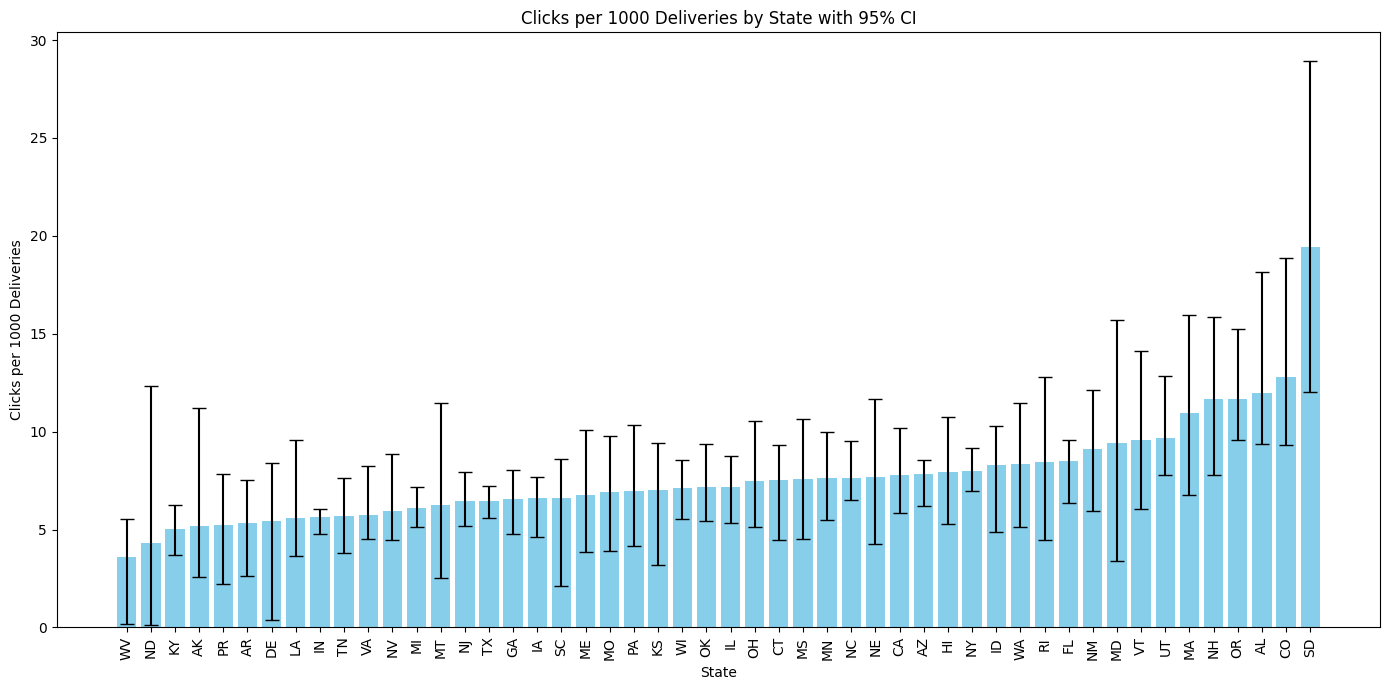

In [ ]:

# Filter out rows with zero mean and confidence intervals
simulation_df = simulation_df[
    (simulation_df['mean'] > 0) &
    (simulation_df['ci_upper'] > 0) &
    (simulation_df['ci_lower'] > 0)
]

# Sort the DataFrame by the mean value
simulation_df.sort_values('mean', inplace=True)

# Calculate error margins for confidence intervals
error = np.array([
    simulation_df['mean'] - simulation_df['ci_lower'],
    simulation_df['ci_upper'] - simulation_df['mean']
])

# Check for shape mismatch
assert len(simulation_df['mean']) == error.shape[1], "Shape mismatch between means and error terms."

# Plot the data
plt.figure(figsize=(14, 7))
plt.bar(
    simulation_df['state'],
    simulation_df['mean'],
    yerr=error,
    capsize=5,
    color='skyblue'
)
plt.title('Clicks per 1000 Deliveries by State with 95% CI')
plt.xlabel('State')
plt.ylabel('Clicks per 1000 Deliveries')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()


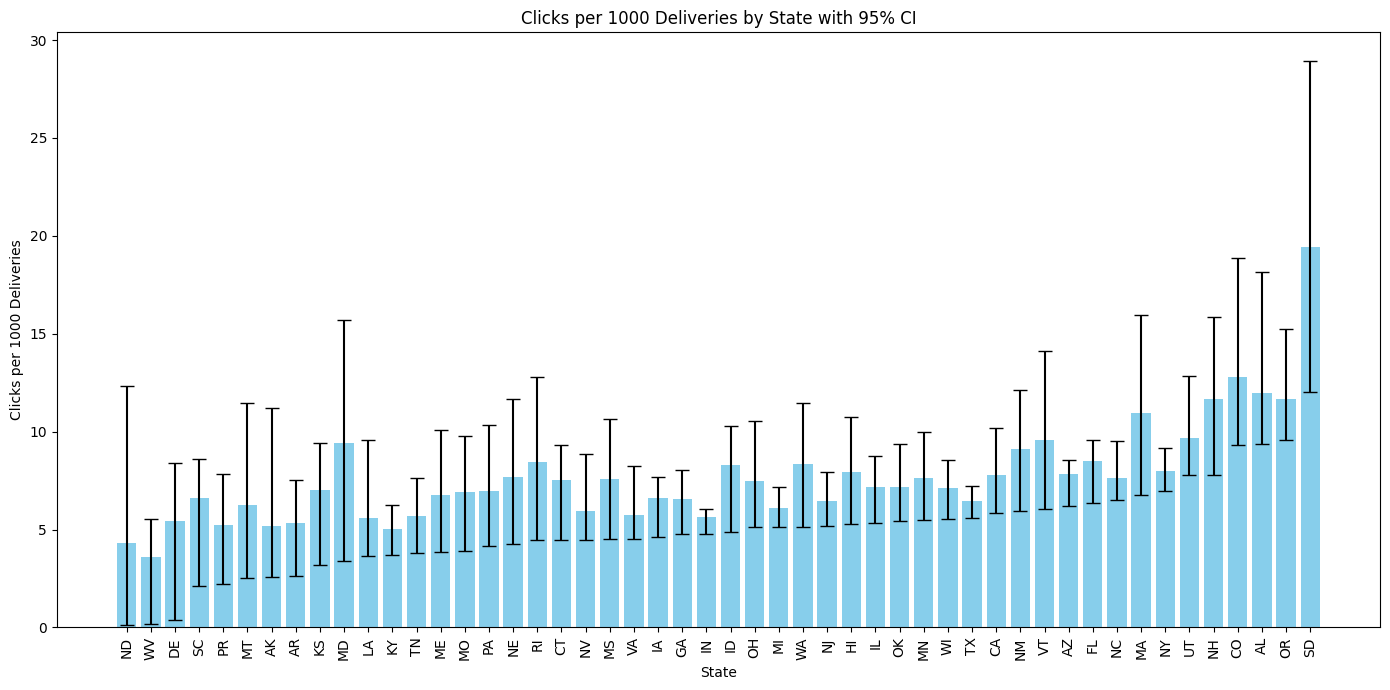

In [ ]:
# sorting the data by confidence interval lower bound for conservative estimate
simulation_df.sort_values('ci_lower', inplace=True)

# Calculate error margins for confidence intervals
error = np.array([
    simulation_df['mean'] - simulation_df['ci_lower'],
    simulation_df['ci_upper'] - simulation_df['mean']
])

# Check for shape mismatch
assert len(simulation_df['mean']) == error.shape[1], "Shape mismatch between means and error terms."

# Plot the data
plt.figure(figsize=(14, 7))
plt.bar(
    simulation_df['state'],
    simulation_df['mean'],
    yerr=error,
    capsize=5,
    color='skyblue'
)
plt.title('Clicks per 1000 Deliveries by State with 95% CI')
plt.xlabel('State')
plt.ylabel('Clicks per 1000 Deliveries')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

In [ ]:
import folium
from folium import Choropleth
import json

# Assuming simulation_df has 'state_full' and 'ci_lower' columns
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Load the local GeoJSON data (adjust path as needed)
with open("D:/DataRepo/github_migration/bulletin_internal_reporting/collateral_renewal_queries/us-states.json", "r") as f:
    geojson_data = json.load(f)

# Create the choropleth map
choropleth = Choropleth(
    geo_data=geojson_data,
    data=simulation_df,
    columns=['state_full', 'ci_lower'],
    key_on="feature.properties.name",  # Link the 'state_full' column to the GeoJSON state names
    fill_color="Blues",
    legend_name="Clicks per 1000 Deliveries"
).add_to(m)

# Add data labels (popups) for each state
for _, row in simulation_df.iterrows():
    state_name = row['state_full']
    ci_value = row['ci_lower']
    
    # Find the corresponding feature in the GeoJSON data
    for feature in geojson_data['features']:
        if feature['properties']['name'] == state_name:
            # Handle multiple geometries by taking the average of all coordinates in the feature
            if feature['geometry']['type'] == 'Polygon':
                coords = feature['geometry']['coordinates'][0]
            elif feature['geometry']['type'] == 'MultiPolygon':
                coords = [point for polygon in feature['geometry']['coordinates'] for point in polygon[0]]

            # Calculate the centroid of the coordinates
            centroid = [sum([point[1] for point in coords])/len(coords), 
                        sum([point[0] for point in coords])/len(coords)]
            
            # Add a popup to the centroid of the state
            folium.Popup(f'{state_name}: {round(ci_value,1)}').add_to(folium.Marker(location=centroid).add_to(m))

# Show the map
m

